In [1]:
import snscrape.modules.twitter as sntwitter
import nltk
nltk.download('punkt')
nltk.download('swadesh')
nltk.download('stopwords')
from nltk.corpus import stopwords,swadesh
from deep_translator import GoogleTranslator
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import PIL.Image
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ricardo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package swadesh to
[nltk_data]     C:\Users\Ricardo\AppData\Roaming\nltk_data...
[nltk_data]   Package swadesh is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ricardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Extrayendo los tweets

In [2]:
query="Olist"
tweets=[]
con=0

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if query in tweet.content:
        con+=1
        tweets.append([tweet.date, tweet.user.username, tweet.content, tweet.lang])
    if con%1000 == 0:
        print(f"se van descargando {con} tweets")


se van descargando 0 tweets
se van descargando 1000 tweets
se van descargando 1000 tweets
se van descargando 2000 tweets
se van descargando 2000 tweets
se van descargando 2000 tweets
se van descargando 3000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets
se van descargando 4000 tweets


Creando un dataframe y viendo idiomas mas usados en las opiniones

In [3]:
data= pd.DataFrame(tweets, columns=["Date", "User", "Tweet", "Lang"])
data["Tweet_en"]=None
idiomas=data.groupby(["Lang"])["Lang"].count()
idiomas.sort_values(ascending=False)


Lang
pt     2149
en     1666
und     155
es      116
et       64
in       43
it       35
de       31
fi       28
tl       10
ja        8
tr        7
fr        7
ca        6
ht        3
ro        3
hu        2
nl        2
pl        2
qme       2
cs        1
ko        1
ru        1
hi        1
eu        1
uk        1
da        1
zh        1
Name: Lang, dtype: int64

Seleccionamos idiomas representativos

In [4]:
data_en=data[data["Lang"] =="en"]
data_es=data[data["Lang"] =="es"]
data_pt=data[data["Lang"] =="pt"]


Funciones a utilizar

In [5]:
stop_words=None
def processing_text(text):
    text=text.lower()
    #re.sub(cadena a buscar, con la que se reemplaza, cadena leida)
    url= ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    menciones='@[\w\-]+'
    hashtag='#[\w\-]+'
    caracteres_especiales=r'\W'
    caracter_individual=r'\s+[a-zA-Z]\s+'
    caracter_individual_inicio=r'\^[a-zA-Z]\s+'
    varios_espacios = r'\s+'
    numeros='[0-9]+'
    prefijo_b=r'^b\s+'
    text=re.sub(url,' ',text)
    text=re.sub(menciones,' ',text)
    text=re.sub(hashtag,' ',text)
    text=re.sub(caracteres_especiales,' ',text)
    text=re.sub(caracter_individual_inicio,' ',text)
    text=re.sub(caracter_individual,' ',text)
    text=re.sub(varios_espacios,' ',text)
    text=re.sub(numeros,' ',text)
    text=re.sub(prefijo_b,' ',text)
    text_tokens=word_tokenize(text)
    filtered_text=[w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)
   
def polarity(text):
    m=TextBlob(text)
    return m.sentiment.polarity

def sentiment(polar):
    if polar <0:
        return("Negative")
    elif polar ==0:
        return("Neutral")
    else:
        return("Positive")
    

Se efectua limpieza de los tweets

In [6]:
stop_words = set(stopwords.words('english'))
data_en["Tweet_en"]=data_en["Tweet"].apply(processing_text)

stop_words = set(stopwords.words('spanish'))
data_es["Tweet_en"]=data_es["Tweet"].apply(processing_text)

stop_words = set(stopwords.words('portuguese'))
data_pt["Tweet_en"]=data_pt["Tweet"].apply(processing_text)


Uniformizando al inglés

In [7]:
translator = GoogleTranslator(source="auto", target="en")
data_es['Tweet_en'] = data_es['Tweet_en'].apply(translator.translate)
data_pt['Tweet_en'] = data_pt['Tweet_en'].apply(translator.translate)


KeyboardInterrupt: 

Concatenando los dataframes


In [166]:
data=pd.concat([data_en,data_es,data_pt])

In [167]:
data.shape

(3929, 5)

In [89]:
data.to_csv("translated.csv")

Con el archivo en ingles derivando

In [9]:
stemmer= PorterStemmer()
def steaming(text):
    text= stemmer.stem(text)
    return text

data["Tweet_en"]=data["Tweet_en"].apply(lambda x : steaming(x))

Quitando usuarios nativos de la empresa Olist

In [10]:
olist_users= set([user for user in data["User"] if "olist" in user])
print(olist_users)
print(data.shape)

{'olistnigeria', 'olistbr'}
(3929, 6)


In [11]:
data=data[data["User"]!="olistbr"]
data=data[data["User"]!="olistnigeria"]
print(data.shape)

(3535, 6)


Polarizando y calculando sentimiento

In [12]:
data["Polarity"]= data["Tweet_en"].apply(polarity)
data["Sentiment"]= data["Polarity"].apply(sentiment)

In [27]:
sentiment=data[["Tweet_en", "Sentiment"]]
sentiment["feeling"]=9

for i,j in enumerate(sentiment["Sentiment"]):
    if j=="Positive":
        sentiment["feeling"].iloc[i]=2
    elif j=="Neutral":
        sentiment["feeling"].iloc[i]=1
    else:
        sentiment["feeling"].iloc[i]=0



In [33]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3535 entries, 0 to 3928
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet_en  3535 non-null   object
 1   feeling   3535 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 211.9+ KB


In [29]:
sentiment.drop(["Sentiment"],axis=1, inplace=True)

In [32]:
sentiment.to_csv("sentiment.csv", index=False)

<AxesSubplot: xlabel='Sentiment', ylabel='count'>

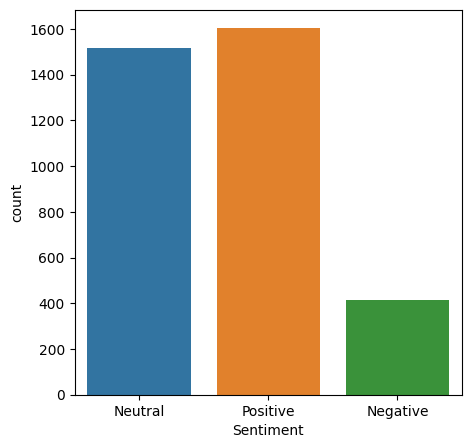

In [13]:
fig= plt.figure(figsize=(5,5))
sns.countplot(x="Sentiment", data=data)

Text(0.5, 1.0, 'Distribution of Sentiments for Olist in Tweeter')

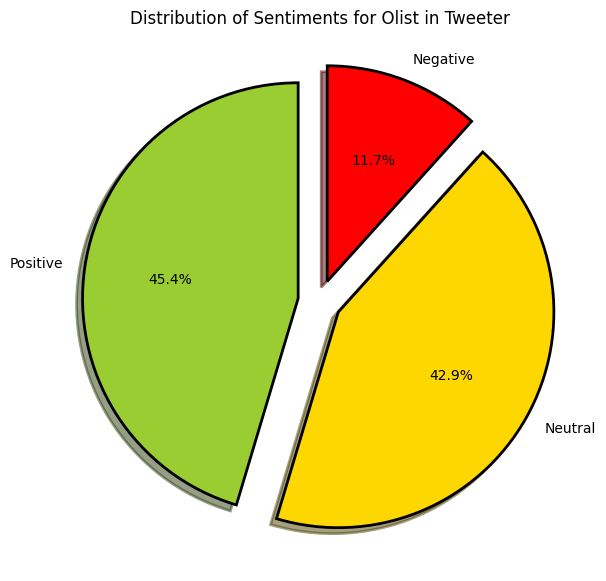

In [14]:
fig=plt.figure(figsize=(7,7))
colors=("yellowgreen","gold","red")
wp={"linewidth":2,"edgecolor":"black"}
tags= data["Sentiment"].value_counts()
explode = (0.1,0.1,0.1)
plt.pie(x=tags,explode=explode,colors=colors,labels=tags.index,
        autopct='%1.1f%%',shadow=True,startangle=90,wedgeprops= wp)
plt.title("Distribution of Sentiments for Olist in Tweeter")

Ahora veamos los 10 tweets de maximo puntaje para cada sentimiento

In [183]:
positive_tweets= data[data["Sentiment"]=="Positive"]
positive_tweets= positive_tweets.sort_values(["Polarity"],ascending=False)
positive_tweets[["Tweet_en","Sentiment","Lang","Polarity"]].head(10)

,Tweet_en,Sentiment,Lang,Polarity
1573,olist best hope among winn,Positive,en,1.0
454,delicious meatpies yes find products jiji olis...,Positive,en,1.0
1886,olist one best apps get need seconds verified sel,Positive,en,1.0
2500,olist best selling platform join today using link,Positive,en,1.0
4041,olist receives award commerce brazil best supp...,Positive,pt,1.0
4040,olist receives award commerce brazil best supp...,Positive,pt,1.0
2988,best price tecno spark olist,Positive,en,1.0
3248,best price iphone olist,Positive,en,1.0
4303,oleaders best olist yet,Positive,en,1.0
4247,olist rock two nights excellent music tuesday ...,Positive,es,1.0


Text(0.5, 1.0, 'Most frequent words in Positive Tweets')

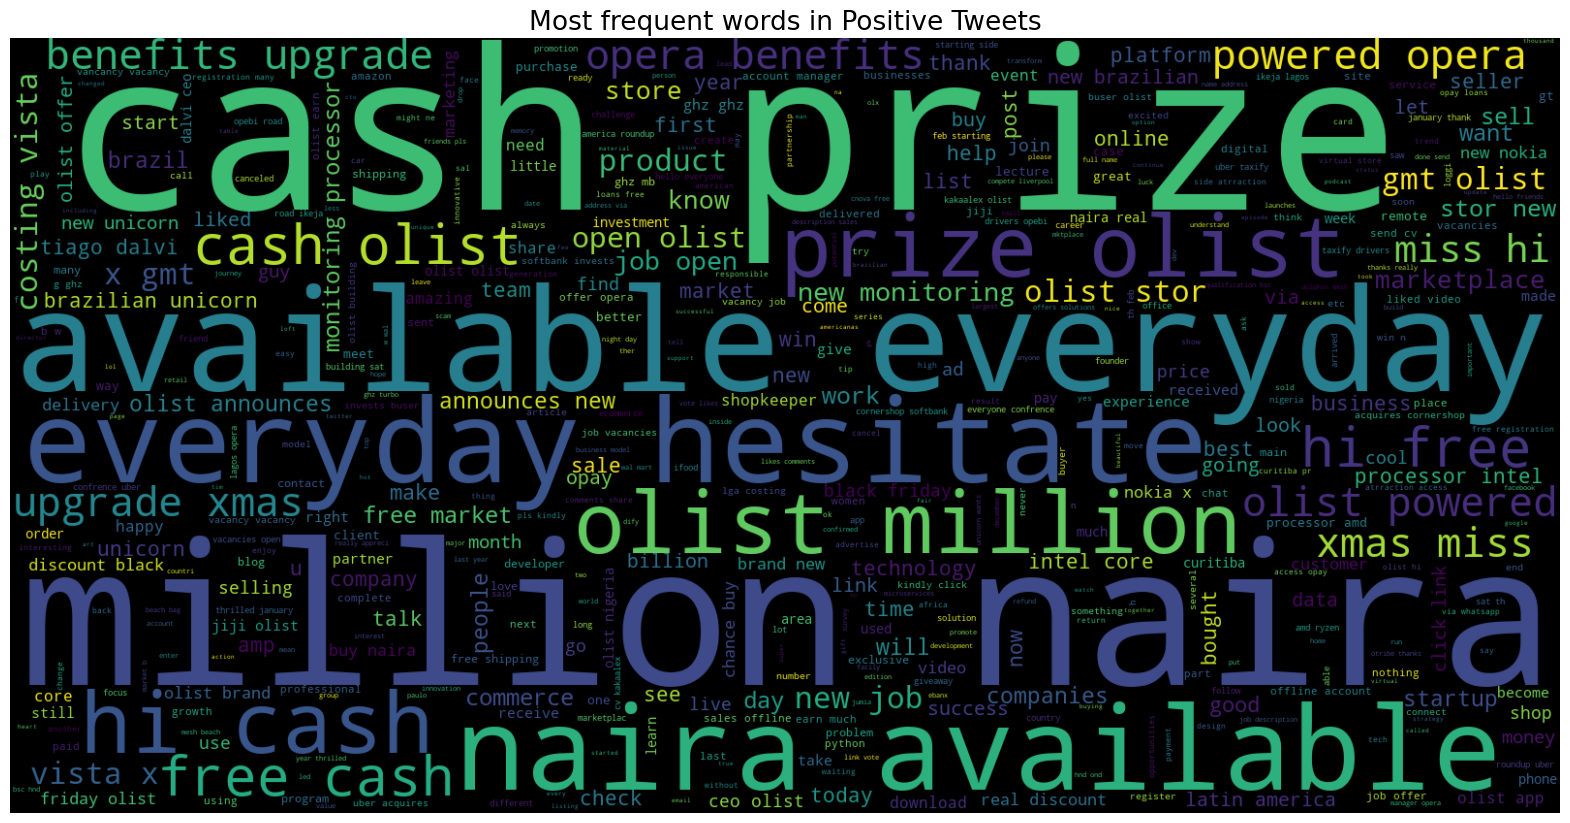

In [240]:
text_pos= " ".join ([word for word in positive_tweets["Tweet_en"]])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud= WordCloud(max_words=500,width=1600,height=800).generate(text_pos)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Most frequent words in Positive Tweets", fontsize=19)

In [185]:
negative_tweets= data[data["Sentiment"]=="Negative"]
negative_tweets= negative_tweets.sort_values(["Polarity"],ascending=True)
negative_tweets[["Tweet_en","Sentiment","Lang","Polarity"]].head(10)

,Tweet_en,Sentiment,Lang,Polarity
1850,imagine jiji olist places terrible places believ,Negative,en,-1.00
2458,i know idea i hated it they put olist product,Negative,pt,-0.90
1575,worst fault olist seller bad character is regi...,Negative,pt,-0.85
2191,hate trekking lagos want car nd shut haters go...,Negative,en,-0.80
332,olist know i hate it,Negative,pt,-0.80
3660,terrible after sales worst seen since day tryi...,Negative,pt,-0.80
143,i bought air conditioning olist nothing they d...,Negative,pt,-0.75
2365,buy shop olist disappointed order arriv,Negative,pt,-0.75
1005,hate this fucking olist,Negative,pt,-0.70
1630,ugly to advertise gloves to have stock a lot o...,Negative,pt,-0.70


Text(0.5, 1.0, 'Most frequent words in Negative Tweets')

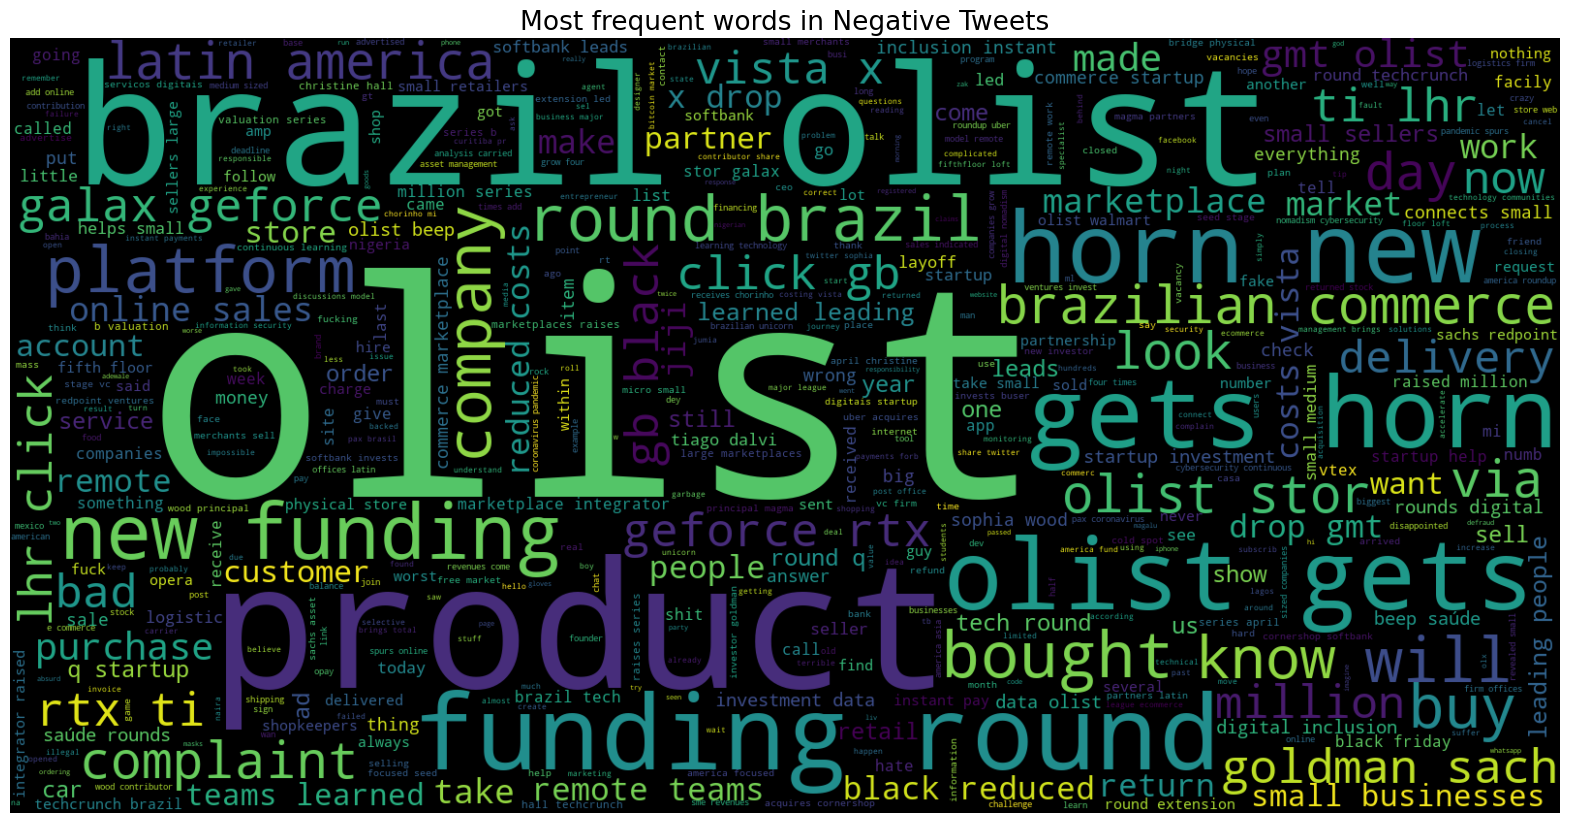

In [188]:
text_neg= " ".join ([word for word in negative_tweets["Tweet_en"]])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud= WordCloud(max_words=500,width=1600,height=800).generate(text_neg)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Most frequent words in Negative Tweets", fontsize=19)

# Vectorización

Modelo de Bigramas

In [1]:
vect=CountVectorizer(ngram_range=(1,2)).fit(data["Tweet_en"])

NameError: name 'CountVectorizer' is not defined

In [11]:
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names[:20])))
print("First 20 features :\n {}".format(feature_names[:20]))

NameError: name 'vect' is not defined

Procediendo a definir el modelo de prediccion

In [193]:
X = data["Tweet_en"]
Y = data["Sentiment"]
X = vect.transform(X)

In [199]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print("Size of x_train : ",x_train.shape)
print("Size of y_train : ",y_train.shape)
print("Size of x_test : ",x_test.shape)
print("Size of y_test : ",y_test.shape)

Size of x_train :  (2474, 23277)
Size of y_train :  (2474,)
Size of x_test :  (1061, 23277)
Size of y_test :  (1061,)


In [219]:
log= LogisticRegression()
log.fit(x_train,y_train)
y_pred_log= log.predict(x_test)
log_acc= accuracy_score(y_pred_log,y_test)
print("Test Accuracy {:.2f}%".format(log_acc*100))

Test Accuracy 86.05%


In [220]:
print(confusion_matrix(y_test,y_pred_log))
print("\n")
print(classification_report(y_test,y_pred_log))

[[ 60  38  23]
 [  2 451  12]
 [  8  65 402]]


              precision    recall  f1-score   support

    Negative       0.86      0.50      0.63       121
     Neutral       0.81      0.97      0.89       465
    Positive       0.92      0.85      0.88       475

    accuracy                           0.86      1061
   macro avg       0.86      0.77      0.80      1061
weighted avg       0.87      0.86      0.85      1061



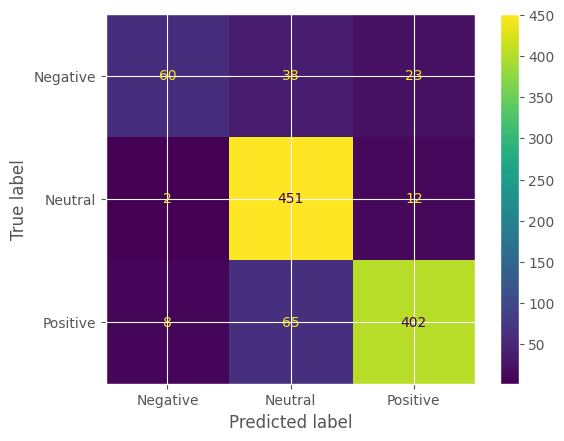

In [221]:
style.use="classic"
cm=confusion_matrix(y_test,y_pred_log,labels=log.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log.classes_)
disp.plot()


Ajuste de hiperparametros

In [215]:
param_grid = {"C":[0.001,0.01,0.1,1,10]}
grid=GridSearchCV(LogisticRegression(),param_grid)
grid.fit(x_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [222]:
print("Best Parameters",grid.best_params_)

Best Parameters {'C': 10}


In [223]:
y_pred_grid= grid.predict(x_test)

In [226]:
grid_log_acc= accuracy_score(y_pred_grid,y_test)
print("Test Accuracy {:.2f}%".format(grid_log_acc*100))

Test Accuracy 86.90%


In [227]:
print(confusion_matrix(y_test,y_pred_grid))
print("\n")
print(classification_report(y_test,y_pred_grid))

[[ 68  33  20]
 [  4 450  11]
 [  9  62 404]]


              precision    recall  f1-score   support

    Negative       0.84      0.56      0.67       121
     Neutral       0.83      0.97      0.89       465
    Positive       0.93      0.85      0.89       475

    accuracy                           0.87      1061
   macro avg       0.86      0.79      0.82      1061
weighted avg       0.87      0.87      0.86      1061



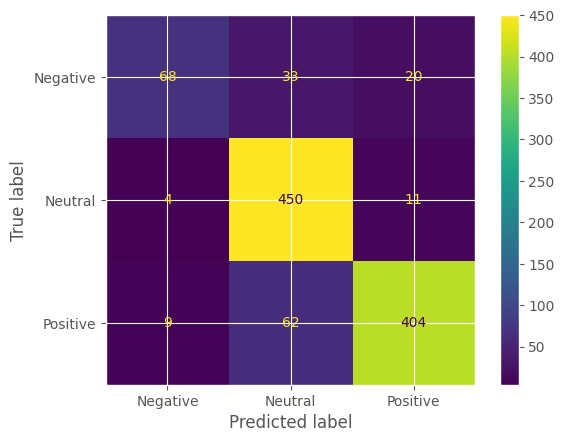

In [228]:
style.use="classic"
cm=confusion_matrix(y_test,y_pred_grid,labels=log.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log.classes_)
disp.plot()